**Training environment for RNN in Neuroscience**

Plan for this notebook :
* Function that solve the differential equation using RK4 to plot RNN behaviors
* Function that generate fake data for training purposes
* Function that does the training
* Function to compute the loss
* Examples

*Remark : at this point, the code tends to diverge when working with big neurons*

### RNN Behaviors

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
def dydx(t,x,W, sigma, mu):
    '''Differential equation'''
    return -x + sigma(W @ x - mu)

def rnn(t, IC, dydx, W, sigma=lambda x: ((1+np.exp(-x))**(-1)), mu=0):
    '''Approximate RNN behaviors using RK4 numerical method
    -----------------------
    t : np.linspace()
        Time array
    IC : Line vector
        Initial condition
    dydx : Function
        Differential equation
    W : Matrix of shape (n_neuron x n_neuron)
        Weight matrix
    sigma : Function
        Activation function (sigmoid if unspecified)
    mu : float/int
        Activation threshold (0 if unspecified)
    ----------------------
    return result and dt
    '''
    n = len(IC)
    m = len(t)
    res = np.zeros((m, n))   #mxn matrix that contain our values
    res[0] = IC  # First line is redefine
    dt = (t[-1] - t[0])/m
    for i in range(1, m):
        k1 = dt * dydx(t[i-1], res[(i-1)], W=W, sigma=sigma, mu=mu)
        k2 = dt * dydx(t[i-1] + 0.5 * dt, res[(i-1)] + 0.5 * k1, W=W, sigma=sigma, mu=mu)
        k3 = dt * dydx(t[i-1] + 0.5 * dt, res[(i-1)] + 0.5 * k2, W=W, sigma=sigma, mu=mu)
        k4 = dt * dydx(t[i-1] + dt, res[(i-1)] + k3, W=W, sigma=sigma, mu=mu)
        res[i] = res[i-1] + (k1 + 2*k2 + 2*k3 + k4)/6
    
    return res, dt

### Generate Data

In [3]:
def GenerateData(n_data, time, IC, W, ratio=0.6, mu=0, sigma=lambda x: (1+np.exp(-x))**(-1)):
    '''
    Generate fake data that follow a RNN function
    -------------------
    n_data : int
        Number of data per neuron
    time : float
        Time of our sample
    IC : Line 
        Initials conditions
    W : Square matrix with shape n_neurons x n_neurons
        Weight Matrix
    ratio : float or int ]0,1]
        Percentage of our fake data that will be use for training
    mu : float or int
        Activation threshold (0 if unspecified)
    sigma : function
        Non-linearities (sigmoid if unspecified)
    -------------------
    Return dict
    '''

    t = np.linspace(0, time, n_data)

    Slice = int(ratio * len(t))
    time_data = t[:Slice]
    Test_Data = np.array([])
    if ratio < 1:
        time_test = t[Slice:]
        Test_Data = rnn(t=time_test, IC=IC, dydx=dydx, W=W, sigma=sigma, mu=mu).T

    Data, dt = rnn(t=time_data, IC=IC, dydx=dydx, W=W, sigma=sigma, mu=mu)
    Data = Data.T

    out = {}
    out["Data"] = Data
    out["Test_Data"] = Test_Data
    out["W"] = W
    out["dt"] = dt
    out["mu"] = mu

    return out

### Training

We use the following equation to represent our behavior :

$\dot{\vec{x}} = -x+\sigma(Wx+\mu)$

With Euler, we have :

$x(t+\Delta t) = x(t) + \Delta x =  x(t)[1-\Delta t]+\sigma(Wx-\mu)\Delta t$

*Model*

In [37]:
class RNNModel(nn.Module):

    def __init__(self, W, dt, mu):
        super(RNNModel, self).__init__()
        self.W = W
        self.dt = dt
        self.mu = mu
    
    def forward(self, x):
        return x * (1-self.dt) + (torch.sigmoid(torch.matmul(self.W, x) - self.mu))*self.dt

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


def Train_RNN(n_neurons, x, dt, mu, lr=1, n_iters=500, verbose=False, loss_graph=False):
    '''
    Function that train our RNN to match a specific model
    ----------------------
    n_neurons : int
        Number of neurons in our RNN
    x : Matrix (n_data x n_neurons) np.array or torch.tensor
        Activity of neuron with their time step
    dt : float/int
        Delta_t (Euler's discretisation)
    mu : int/float
        Activity threshold (same for true data and predicted)
    lr : int/float
        learning rate(1 if unspecified)
    n_iters : int
        number of iteration (epochs) (500 if unspecified)
    verbose : bool
        Update on epochs (False if unspecified)
    loss_graph : bool
        Plot loss function
    ----------------------
    return dict
    '''
    
    #Convert activity to tensor
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)
    
    #Set up
    W = torch.randn(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = nn.Parameter(W)  #Parameter that will be modify
    
    model = RNNModel(W=W, dt=dt, mu=mu)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss = nn.MSELoss()

    Total_loss = []

    #Keeping our inital matrix for later
    with torch.no_grad():
        W0 = W.clone()

    #Training
    for epoch in range(n_iters):
        #Forward pass
        x_pred = torch.zeros(x.shape[0], x.shape[1])
        x_pred[0] = x[0]  #insert IC

        for i in range(x.shape[0] - 1):
            x_pred[i+1] = model(x[i])
        
        #Loss
        l = loss(x, x_pred)

        #Gradient
        l.backward()

        #update weight matrix
        optimizer.step()
        optimizer.zero_grad()

        if verbose:
            if (epoch+1) % 100 == 1:
                print(f"epoch {epoch}/{n_iters} loss {l:.6f}")

        with torch.no_grad():
            Total_loss.append(l.numpy())

    out = {}
    out["W"] = W.detach().numpy()
    out["W0"] = W0.detach().numpy()
    out["params"] = {}
    out["params"]["dt"] = dt
    out["params"]["lr"] = lr
    out["params"]["mu"] = mu
    out["params"]["lr"] = lr
    out["params"]["n_iters"] = n_iters
    out["params"]["optim"] = f"{optimizer}"
    out["params"]["loss"] = f"{loss}"


    if loss_graph:
        t = np.linspace(0, n_iters, len(Total_loss))
        plt.plot(t, Total_loss, "r-")
        plt.grid(True)
        plt.title(f"Loss function with lr = {lr}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
    
    return out



In [50]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


def Train_RNN2(n_neurons, x, dt, mu, lr=1, n_iters=500, verbose=False, loss_graph=False):
    '''
    Function that train our RNN to match a specific model
    ----------------------
    n_neurons : int
        Number of neurons in our RNN
    x : Matrix (n_data x n_neurons) np.array or torch.tensor
        Activity of neuron with their time step
    dt : float/int
        Delta_t (Euler's discretisation)
    mu : int/float
        Activity threshold (same for true data and predicted)
    lr : int/float
        learning rate(1 if unspecified)
    n_iters : int
        number of iteration (epochs) (500 if unspecified)
    verbose : bool
        Update on epochs (False if unspecified)
    loss_graph : bool
        Plot loss function
    ----------------------
    return dict
    '''
    
    #Convert activity to tensor
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)
    
    #Set up
    W = torch.randn(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = nn.Parameter(W)  #Parameter that will be modify
    
    model = RNNModel(W=W, dt=dt, mu=mu)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss = nn.MSELoss()

    Total_loss = []

    #Keeping our inital matrix for later
    with torch.no_grad():
        W0 = W.clone()

    #Training
    for epoch in range(n_iters):
        #Forward pass
        x_pred = torch.zeros(x.shape[0], x.shape[1])
        x_pred[0] = x[0]  #insert IC

        x_pred_temp = model(x[:-1].T)
        x_pred[1:] = x_pred_temp.T

        
        #Loss
        l = loss(x, x_pred)

        #Gradient
        l.backward()

        #update weight matrix
        optimizer.step()
        optimizer.zero_grad()

        if verbose:
            if (epoch+1) % 100 == 1:
                print(f"epoch {epoch}/{n_iters} loss {l:.6f}")

        with torch.no_grad():
            Total_loss.append(l.numpy())

    out = {}
    out["W"] = W.detach().numpy()
    out["W0"] = W0.detach().numpy()
    out["params"] = {}
    out["params"]["dt"] = dt
    out["params"]["lr"] = lr
    out["params"]["mu"] = mu
    out["params"]["lr"] = lr
    out["params"]["n_iters"] = n_iters
    out["params"]["optim"] = f"{optimizer}"
    out["params"]["loss"] = f"{loss}"


    if loss_graph:
        t = np.linspace(0, n_iters, len(Total_loss))
        plt.plot(t, Total_loss, "r-")
        plt.grid(True)
        plt.title(f"Loss function with lr = {lr}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
    
    return out



### Example 2x2 matrix

epoch 0/1000 loss 0.000278
epoch 100/1000 loss 0.000004
epoch 200/1000 loss 0.000002
epoch 300/1000 loss 0.000002
epoch 400/1000 loss 0.000002
epoch 500/1000 loss 0.000002
epoch 600/1000 loss 0.000002
epoch 700/1000 loss 0.000002
epoch 800/1000 loss 0.000002
epoch 900/1000 loss 0.000002


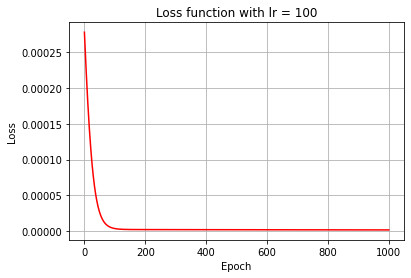

In [7]:
n=2
a = GenerateData(n_data=50, time=5, IC=np.random.rand(n), W=np.random.randn(n, n), ratio=1)

Prediction = Train_RNN(2, a["Data"].T, a["dt"], mu=a["mu"], n_iters=1000, lr=100, verbose=True, loss_graph=True)

W = Prediction["W"]

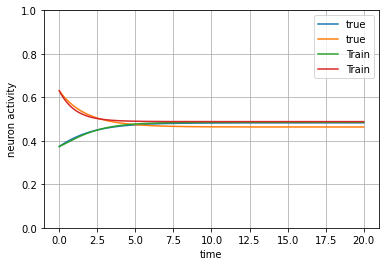

In [8]:
t = np.linspace(0, 20, 10000)
IC = (a["Data"].T)[0]

x_true = rnn(t=t, IC=IC, dydx=dydx, W=a["W"])[0]
#x_untrain = rnn(t=t, IC=IC, dydx=dydx, W=Prediction["W0"])[0]
x_train = rnn(t=t, IC=IC, dydx=dydx, W=Prediction["W"])[0]


plt.plot(t, x_true, label="true")
#plt.plot(t, x_untrain, label="Untrain")
plt.plot(t, x_train, label="Train")
plt.xlabel("time")
plt.ylabel("neuron activity")
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

### Example 4x4 Matrix

epoch 0/2000 loss 0.000864
epoch 100/2000 loss 0.000017
epoch 200/2000 loss 0.000008
epoch 300/2000 loss 0.000006
epoch 400/2000 loss 0.000006
epoch 500/2000 loss 0.000005
epoch 600/2000 loss 0.000005
epoch 700/2000 loss 0.000004
epoch 800/2000 loss 0.000004
epoch 900/2000 loss 0.000003
epoch 1000/2000 loss 0.000003
epoch 1100/2000 loss 0.000003
epoch 1200/2000 loss 0.000002
epoch 1300/2000 loss 0.000002
epoch 1400/2000 loss 0.000002
epoch 1500/2000 loss 0.000002
epoch 1600/2000 loss 0.000002
epoch 1700/2000 loss 0.000001
epoch 1800/2000 loss 0.000001
epoch 1900/2000 loss 0.000001


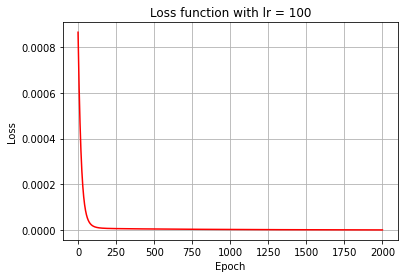

In [13]:
n=4
a = GenerateData(n_data=50, time=5, IC=np.random.rand(n), W=np.random.randn(n, n), ratio=1)

Prediction = Train_RNN(4, a["Data"].T, a["dt"], mu=a["mu"], n_iters=2000, lr=100, verbose=True, loss_graph=True)


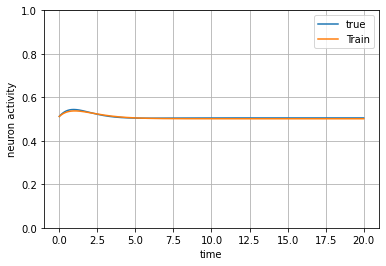

In [15]:
t = np.linspace(0, 20, 10000)
IC = (a["Data"].T)[0]

x_true = rnn(t=t, IC=IC, dydx=dydx, W=a["W"])[0]
#x_untrain = rnn(t=t, IC=IC, dydx=dydx, W=Prediction["W0"])[0]
x_train = rnn(t=t, IC=IC, dydx=dydx, W=Prediction["W"])[0]


plt.plot(t, x_true[:,1], label="true")
#plt.plot(t, x_untrain, label="Untrain")
plt.plot(t, x_train[:,1], label="Train")
plt.xlabel("time")
plt.ylabel("neuron activity")
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

### Example 20 x 20

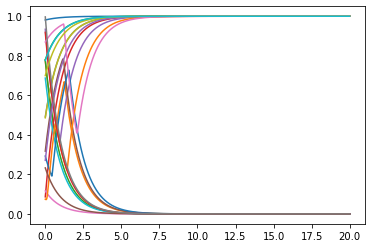

In [16]:
n=20
IC=np.random.rand(n)
a = GenerateData(n_data=50, time=5, IC=IC, W=100*np.random.randn(n, n), ratio=1)

W_true = a["W"]
t = np.linspace(0, 20, 1000)
plt.plot(t, rnn(t=t, IC=IC, dydx=dydx, W=W_true)[0])
plt.show()  #See 7th neuron

epoch 0/2000 loss 0.003145
epoch 100/2000 loss 0.000263
epoch 200/2000 loss 0.000177
epoch 300/2000 loss 0.000138
epoch 400/2000 loss 0.000117
epoch 500/2000 loss 0.000103
epoch 600/2000 loss 0.000094
epoch 700/2000 loss 0.000087
epoch 800/2000 loss 0.000081
epoch 900/2000 loss 0.000077
epoch 1000/2000 loss 0.000073
epoch 1100/2000 loss 0.000070
epoch 1200/2000 loss 0.000067
epoch 1300/2000 loss 0.000065
epoch 1400/2000 loss 0.000062
epoch 1500/2000 loss 0.000060
epoch 1600/2000 loss 0.000059
epoch 1700/2000 loss 0.000057
epoch 1800/2000 loss 0.000055
epoch 1900/2000 loss 0.000054


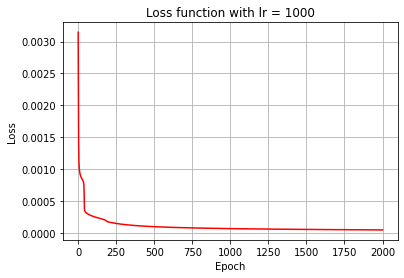

In [17]:
Prediction = Train_RNN(20, a["Data"].T, a["dt"], mu=a["mu"], n_iters=2000, lr=1000, verbose=True, loss_graph=True)

When dealing with those types of neurons, we can see that neurons that tend to converge get trains really well. We can see how the 10th neurons is train :

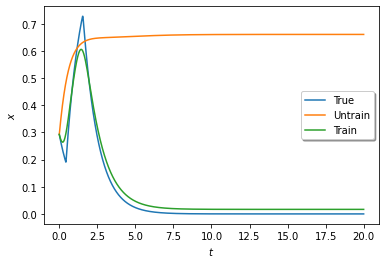

In [18]:
t = np.linspace(0, 20, 10000)
IC = (a["Data"].T)[0]

x_true = rnn(t=t, IC=IC, dydx=dydx, W=a["W"])[0]
x_untrain = rnn(t=t, IC=IC, dydx=dydx, W=Prediction["W0"])[0]
x_train = rnn(t=t, IC=IC, dydx=dydx, W=Prediction["W"])[0]

plt.plot(t, x_true[:,10], label="True")
plt.plot(t, x_untrain[:,10], label="Untrain")
plt.plot(t, x_train[:,10], label="Train")
plt.xlabel(r"$t$")
plt.ylabel(r"$x$")
plt.legend(shadow=True, fancybox=True)
plt.show()

We can see that when dealing with a neuron that has a oscillation behavior, the training tends to go to the average of the oscillation.

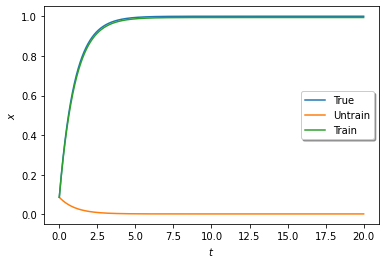

In [21]:
t = np.linspace(0, 20, 10000)
IC = (a["Data"].T)[0]

x_true = rnn(t=t, IC=IC, dydx=dydx, W=a["W"])[0]
x_untrain = rnn(t=t, IC=IC, dydx=dydx, W=Prediction["W0"])[0]
x_train = rnn(t=t, IC=IC, dydx=dydx, W=Prediction["W"])[0]

plt.plot(t, x_true[:,3], label="True")
plt.plot(t, x_untrain[:,3], label="Untrain")
plt.plot(t, x_train[:,3], label="Train")
plt.xlabel(r"$t$")
plt.ylabel(r"$x$")
plt.legend(shadow=True, fancybox=True)
plt.show()

**Increase our algorithm**

Here, we will try different approch to increase the quality of our learning. We will begin with :
- Mean matrix
- Adaptative learning rate

### Mean matrix 

We will now try to do the mean of the matrix $\mathbf{W}$ to ameliorate our model

In [26]:
n = 20
IC = np.random.rand(n)
a = GenerateData(n_data=25, time=5, IC=IC, W=5*np.random.randn(n,n), ratio=1)

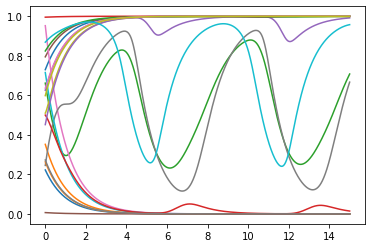

In [36]:
W_true = a["W"]
t = np.linspace(0, 15, 1000)
plt.plot(t, rnn(t=t, IC=IC, dydx=dydx, W=W_true)[0])
plt.show()

In [57]:
list_W = []
for i in range(10):
    pred = Train_RNN(20, a["Data"].T, a["dt"], mu=a["mu"], n_iters=2000, verbose=True, lr=1)
    list_W.append(pred["W"])

epoch 0/2000 loss 0.014145
epoch 100/2000 loss 0.013150
epoch 200/2000 loss 0.012312
epoch 300/2000 loss 0.011601
epoch 400/2000 loss 0.011001
epoch 500/2000 loss 0.010496
epoch 600/2000 loss 0.010060
epoch 700/2000 loss 0.009692
epoch 800/2000 loss 0.009404
epoch 900/2000 loss 0.009188
epoch 1000/2000 loss 0.009027
epoch 1100/2000 loss 0.008901
epoch 1200/2000 loss 0.008798
epoch 1300/2000 loss 0.008710
epoch 1400/2000 loss 0.008631
epoch 1500/2000 loss 0.008556
epoch 1600/2000 loss 0.008482
epoch 1700/2000 loss 0.008405
epoch 1800/2000 loss 0.008319
epoch 1900/2000 loss 0.008216
epoch 0/2000 loss 0.015957
epoch 100/2000 loss 0.014326
epoch 200/2000 loss 0.012948
epoch 300/2000 loss 0.011915
epoch 400/2000 loss 0.011198
epoch 500/2000 loss 0.010703
epoch 600/2000 loss 0.010344
epoch 700/2000 loss 0.010063
epoch 800/2000 loss 0.009824
epoch 900/2000 loss 0.009606
epoch 1000/2000 loss 0.009395
epoch 1100/2000 loss 0.009185
epoch 1200/2000 loss 0.008976
epoch 1300/2000 loss 0.008769
epoc

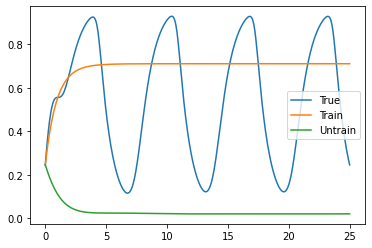

In [67]:
moy = np.mean(list_W, axis=0)

t = np.linspace(0, 25, 1000)
plt.plot(t, rnn(t=t, IC=IC, dydx=dydx, W=W_true)[0][:,7], label="True")
plt.plot(t, rnn(t=t, IC=IC, dydx=dydx, W=moy)[0][:,7], label="Train")
plt.plot(t, rnn(t=t, IC=IC, dydx=dydx, W=pred["W0"])[0][:,7], label="Untrain")
plt.legend()
plt.show()

### Adaptative learning rate

This method allows us to identify the perfect learning rate. We will modify our learning rate exponentially. Let's use the following function :

$lr = 0.1e^{0,007\text{epoch}}$

In [74]:
import numpy as np

def learn_rate(epoch):
    return 0.01 * np.exp(0.0055 * epoch)

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


def Train_RNN_AdaptLR(n_neurons, x, dt, mu, n_iters=500, verbose=False, loss_graph=False):
    
    #Convert activity to tensor
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)
    
    #Set up
    W = torch.randn(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = nn.Parameter(W)  #Parameter that will be modify

    Learning_rates = []
    Total_loss = []

    #Keeping our inital matrix for later
    with torch.no_grad():
        W0 = W.clone()

    #Training
    for epoch in range(n_iters):
        model = RNNModel(W=W, dt=dt, mu=mu)

        lr = learn_rate(epoch)
        Learning_rates.append(lr)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        loss = nn.MSELoss()
        #Forward pass
        x_pred = torch.zeros(x.shape[0], x.shape[1])
        x_pred[0] = x[0]  #insert IC

        for i in range(x.shape[0]):
            if (i+1) == x.shape[0]:
                continue
            else:
                x_pred[i+1] = model(x[i])
        
        #Loss
        l = loss(x, x_pred)

        #Gradient
        l.backward()

        #update weight matrix
        optimizer.step()
        optimizer.zero_grad()

        if verbose:
            if (epoch+1) % 100 == 1:
                print(f"epoch {epoch}/{n_iters} loss {l:.6f}")

        with torch.no_grad():
            Total_loss.append(l.numpy())

    out = {}
    out["W"] = W.detach().numpy()
    out["W0"] = W0.detach().numpy()
    out["params"] = {}
    out["params"]["dt"] = dt
    out["params"]["lr"] = lr
    out["params"]["mu"] = mu
    out["params"]["lr"] = Learning_rates
    out["params"]["loss"] = Total_loss
    out["params"]["n_iters"] = n_iters
    out["params"]["optim"] = f"{optimizer}"


    if loss_graph:
        plt.plot(Learning_rates, Total_loss, "r-")
        plt.xlabel("learning rate (log)")
        plt.ylabel("loss")
        plt.xscale("log")
        plt.title(f"learning rate when working with {n_neurons} neurons")
        plt.show()
    
    return out



epoch 0/4000 loss 0.001353
epoch 100/4000 loss 0.001352
epoch 200/4000 loss 0.001352
epoch 300/4000 loss 0.001351
epoch 400/4000 loss 0.001350
epoch 500/4000 loss 0.001348
epoch 600/4000 loss 0.001344
epoch 700/4000 loss 0.001338
epoch 800/4000 loss 0.001326
epoch 900/4000 loss 0.001307
epoch 1000/4000 loss 0.001274
epoch 1100/4000 loss 0.001219
epoch 1200/4000 loss 0.001129
epoch 1300/4000 loss 0.000984
epoch 1400/4000 loss 0.000754
epoch 1500/4000 loss 0.000341
epoch 1600/4000 loss 0.000166
epoch 1700/4000 loss 0.000094
epoch 1800/4000 loss 0.000005
epoch 1900/4000 loss 0.000004
epoch 2000/4000 loss 0.000004
epoch 2100/4000 loss 0.000003
epoch 2200/4000 loss 0.000003
epoch 2300/4000 loss 0.000002
epoch 2400/4000 loss 0.000001
epoch 2500/4000 loss 0.000128
epoch 2600/4000 loss 0.000572
epoch 2700/4000 loss 0.000524
epoch 2800/4000 loss 0.000806
epoch 2900/4000 loss 0.000834
epoch 3000/4000 loss 0.001123
epoch 3100/4000 loss 0.001123
epoch 3200/4000 loss 0.001114
epoch 3300/4000 loss 0

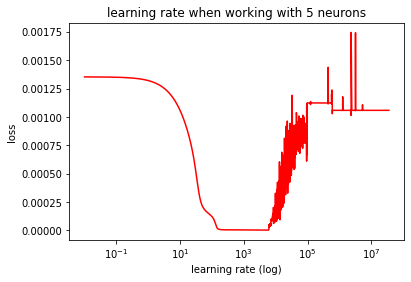

In [75]:
n = 5
IC = np.random.randn(n)

data = GenerateData(n_data = 40, time=5, IC=IC, W=np.random.randn(n,n), ratio=1)

pred = Train_RNN_AdaptLR(5, data["Data"].T, a["dt"], mu=a["mu"], n_iters=4000, verbose=True, loss_graph=True)

epoch 0/4000 loss 0.012776
epoch 100/4000 loss 0.012775
epoch 200/4000 loss 0.012775
epoch 300/4000 loss 0.012774
epoch 400/4000 loss 0.012773
epoch 500/4000 loss 0.012771
epoch 600/4000 loss 0.012768
epoch 700/4000 loss 0.012761
epoch 800/4000 loss 0.012751
epoch 900/4000 loss 0.012732
epoch 1000/4000 loss 0.012700
epoch 1100/4000 loss 0.012645
epoch 1200/4000 loss 0.012547
epoch 1300/4000 loss 0.012369
epoch 1400/4000 loss 0.012018
epoch 1500/4000 loss 0.011245
epoch 1600/4000 loss 0.010005
epoch 1700/4000 loss 0.008794
epoch 1800/4000 loss 0.007039
epoch 1900/4000 loss 0.003713
epoch 2000/4000 loss 0.002743
epoch 2100/4000 loss 0.001250
epoch 2200/4000 loss 0.000349
epoch 2300/4000 loss 0.000161
epoch 2400/4000 loss 0.000103
epoch 2500/4000 loss 0.000075
epoch 2600/4000 loss 0.000051
epoch 2700/4000 loss 0.000588
epoch 2800/4000 loss 0.001423
epoch 2900/4000 loss 0.001821
epoch 3000/4000 loss 0.002367
epoch 3100/4000 loss 0.002286
epoch 3200/4000 loss 0.002779
epoch 3300/4000 loss 0

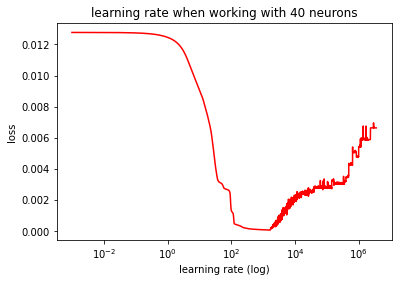

In [85]:
n = 40
IC = np.random.rand(n)

data = GenerateData(n_data = 40, time=5, IC=IC, W=np.random.randn(n,n), ratio=1)

pred = Train_RNN_AdaptLR(40, data["Data"].T, a["dt"], mu=a["mu"], n_iters=4000, verbose=True)

plt.plot(pred["params"]["lr"], pred["params"]["loss"], "r-")
plt.xlabel("learning rate (log)")
plt.ylabel("loss")
plt.xscale("log")
plt.title("learning rate when working with 40 neurons")
plt.show()

We can see that a learning rate between $10^2$ and $10^3$ seems to generate the smallest loss

epoch 0/5000 loss 0.012649
epoch 100/5000 loss 0.001693
epoch 200/5000 loss 0.000937
epoch 300/5000 loss 0.000404
epoch 400/5000 loss 0.000395
epoch 500/5000 loss 0.000390
epoch 600/5000 loss 0.000386
epoch 700/5000 loss 0.000384
epoch 800/5000 loss 0.000383
epoch 900/5000 loss 0.000381
epoch 1000/5000 loss 0.000380
epoch 1100/5000 loss 0.000380
epoch 1200/5000 loss 0.000379
epoch 1300/5000 loss 0.000378
epoch 1400/5000 loss 0.000378
epoch 1500/5000 loss 0.000377
epoch 1600/5000 loss 0.000377
epoch 1700/5000 loss 0.000377
epoch 1800/5000 loss 0.000376
epoch 1900/5000 loss 0.000376
epoch 2000/5000 loss 0.000375
epoch 2100/5000 loss 0.000375
epoch 2200/5000 loss 0.000372
epoch 2300/5000 loss 0.000007
epoch 2400/5000 loss 0.000005
epoch 2500/5000 loss 0.000004
epoch 2600/5000 loss 0.000004
epoch 2700/5000 loss 0.000004
epoch 2800/5000 loss 0.000003
epoch 2900/5000 loss 0.000003
epoch 3000/5000 loss 0.000003
epoch 3100/5000 loss 0.000003
epoch 3200/5000 loss 0.000003
epoch 3300/5000 loss 0

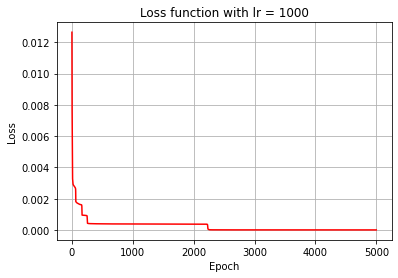

In [90]:
t = np.linspace(0, 20, 1000)

pred = Train_RNN(40, data["Data"].T, a["dt"], mu=a["mu"], n_iters=5000, lr=1000, verbose=True, loss_graph=True)

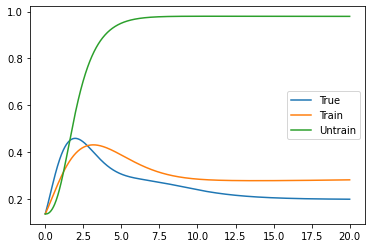

In [109]:
plt.plot(t, rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0][:,34], label="True")
plt.plot (t, rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0][:,34], label="Train")
plt.plot(t, rnn(t=t, IC=IC, dydx=dydx, W=pred["W0"])[0][:,34], label="Untrain")
plt.legend()
plt.show()

This model turns out to be extremly precise. Let's try with a bigger sample. Also, we will add a treshhold $\mu$

C:\Users\Anthony\AppData\Local\Temp\ipykernel_2736\989979414.py:1: RuntimeWarning: overflow encountered in exp
  def GenerateData(n_data, time, IC, W, ratio=0.6, mu=0, sigma=lambda x: (1+np.exp(-x))**(-1)):
C:\Users\Anthony\AppData\Local\Temp\ipykernel_2736\1086228128.py:5: RuntimeWarning: overflow encountered in exp
  def rnn(t, IC, dydx, W, sigma=lambda x: ((1+np.exp(-x))**(-1)), mu=0):


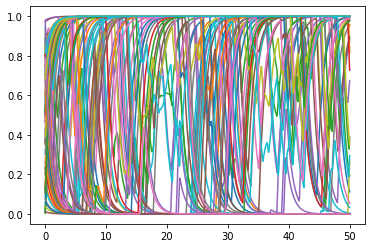

In [9]:
n = 100
IC = np.random.rand(n)

t = np.linspace(0,50,1000)

data = GenerateData(n_data=100, time=50, IC=IC, W=80*np.random.randn(n, n), ratio=1, mu=2)

plt.plot(t, rnn(t=t, IC=IC, dydx=dydx, W=data["W"], mu=0.5)[0])
plt.show()

epoch 0/4000 loss 0.004531
epoch 100/4000 loss 0.004530
epoch 200/4000 loss 0.004530
epoch 300/4000 loss 0.004528
epoch 400/4000 loss 0.004526
epoch 500/4000 loss 0.004522
epoch 600/4000 loss 0.004515
epoch 700/4000 loss 0.004503
epoch 800/4000 loss 0.004483
epoch 900/4000 loss 0.004447
epoch 1000/4000 loss 0.004385
epoch 1100/4000 loss 0.004278
epoch 1200/4000 loss 0.004097
epoch 1300/4000 loss 0.003825
epoch 1400/4000 loss 0.003487
epoch 1500/4000 loss 0.003155
epoch 1600/4000 loss 0.002884
epoch 1700/4000 loss 0.002750
epoch 1800/4000 loss 0.002585
epoch 1900/4000 loss 0.002315
epoch 2000/4000 loss 0.001915
epoch 2100/4000 loss 0.001526
epoch 2200/4000 loss 0.001101
epoch 2300/4000 loss 0.000947
epoch 2400/4000 loss 0.000934
epoch 2500/4000 loss 0.000816
epoch 2600/4000 loss 0.000805
epoch 2700/4000 loss 0.000701
epoch 2800/4000 loss 0.000502
epoch 2900/4000 loss 0.000485
epoch 3000/4000 loss 0.000529
epoch 3100/4000 loss 0.000544
epoch 3200/4000 loss 0.000540
epoch 3300/4000 loss 0

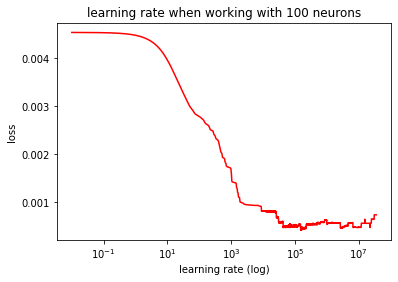

In [82]:
learn = Train_RNN_AdaptLR(100, data["Data"].T, a["dt"], mu=data["mu"], n_iters=4000, verbose=True, loss_graph=True)

epoch 0/8000 loss 0.092704
epoch 100/8000 loss 0.022850
epoch 200/8000 loss 0.022850
epoch 300/8000 loss 0.022249
epoch 400/8000 loss 0.019781
epoch 500/8000 loss 0.019780
epoch 600/8000 loss 0.019781
epoch 700/8000 loss 0.019769
epoch 800/8000 loss 0.019769
epoch 900/8000 loss 0.019770
epoch 1000/8000 loss 0.019770
epoch 1100/8000 loss 0.019769
epoch 1200/8000 loss 0.019770
epoch 1300/8000 loss 0.019769
epoch 1400/8000 loss 0.019769
epoch 1500/8000 loss 0.019769
epoch 1600/8000 loss 0.019769
epoch 1700/8000 loss 0.019769
epoch 1800/8000 loss 0.019769
epoch 1900/8000 loss 0.019769
epoch 2000/8000 loss 0.019769
epoch 2100/8000 loss 0.019769
epoch 2200/8000 loss 0.019769
epoch 2300/8000 loss 0.019769
epoch 2400/8000 loss 0.019769
epoch 2500/8000 loss 0.019769
epoch 2600/8000 loss 0.019769
epoch 2700/8000 loss 0.019769
epoch 2800/8000 loss 0.019769
epoch 2900/8000 loss 0.019769
epoch 3000/8000 loss 0.019769
epoch 3100/8000 loss 0.019769
epoch 3200/8000 loss 0.019769
epoch 3300/8000 loss 0

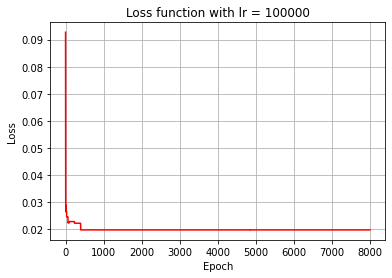

In [14]:
pred = Train_RNN(100, data["Data"].T, data["dt"], mu=data["mu"], n_iters=8000, lr=100000, verbose=True, loss_graph=True)

epoch 0/1000 loss 0.017812
epoch 100/1000 loss 0.009113
epoch 200/1000 loss 0.007410
epoch 300/1000 loss 0.006173
epoch 400/1000 loss 0.005813
epoch 500/1000 loss 0.005744
epoch 600/1000 loss 0.005684
epoch 700/1000 loss 0.005458
epoch 800/1000 loss 0.005070
epoch 900/1000 loss 0.004598


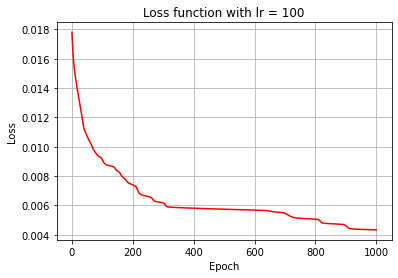

In [218]:
pred2 = Train_RNN(100, data["Data"].T, a["dt"], mu=data["mu"], n_iters=1000, lr=100, verbose=True, loss_graph=True)

C:\Users\antho\AppData\Local\Temp/ipykernel_25724/1086228128.py:5: RuntimeWarning: overflow encountered in exp
  def rnn(t, IC, dydx, W, sigma=lambda x: ((1+np.exp(-x))**(-1)), mu=0):


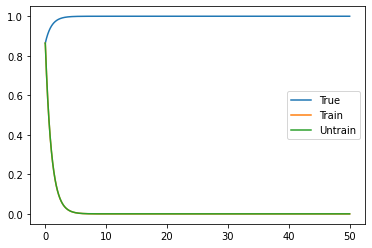

In [232]:
t = np.linspace(0,50,1000)

plt.plot(t, rnn(t=t, IC=IC, dydx=dydx, W=data["W"], mu=data["mu"])[0][:,33], label="True")
plt.plot(t, rnn(t=t, IC=IC, dydx=dydx, W=pred2["W"], mu=pred2["params"]["mu"])[0][:,33], label="Train")
plt.plot(t, rnn(t=t, IC=IC, dydx=dydx, W=pred2["W0"], mu=pred2["params"]["mu"])[0][:,33], label="Untrain")
plt.legend()
plt.show()

In [6]:
n = 500
IC = np.random.rand(n)

data = GenerateData(n_data=(400), time=30, IC=IC, W=2*np.random.randn(n,n), ratio=1, mu=0.5)

t = np.linspace(0, 20, 100)

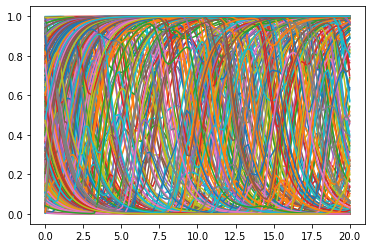

In [7]:
plt.plot(t, rnn(t=t, IC=IC, dydx=dydx, W=data["W"], mu=data["mu"])[0][:])
plt.show()

In [71]:
lr_test = Train_RNN_AdaptLR(500, data["Data"].T, data["dt"], mu=data["mu"], n_iters=3000, verbose=True)

epoch 0/3000 loss 0.001988
epoch 100/3000 loss 0.001988
epoch 200/3000 loss 0.001988
epoch 300/3000 loss 0.001988
epoch 400/3000 loss 0.001988
epoch 500/3000 loss 0.001988
epoch 600/3000 loss 0.001988
epoch 700/3000 loss 0.001987
epoch 800/3000 loss 0.001987
epoch 900/3000 loss 0.001985
epoch 1000/3000 loss 0.001983
epoch 1100/3000 loss 0.001978
epoch 1200/3000 loss 0.001971
epoch 1300/3000 loss 0.001958
epoch 1400/3000 loss 0.001936
epoch 1500/3000 loss 0.001900
epoch 1600/3000 loss 0.001846
epoch 1700/3000 loss 0.001767
epoch 1800/3000 loss 0.001653
epoch 1900/3000 loss 0.001501
epoch 2000/3000 loss 0.001350
epoch 2100/3000 loss 0.001254
epoch 2200/3000 loss 0.001142
epoch 2300/3000 loss 0.001036
epoch 2400/3000 loss 0.000894
epoch 2500/3000 loss 0.000815
epoch 2600/3000 loss 0.000727
epoch 2700/3000 loss 0.000655
epoch 2800/3000 loss 0.000594
epoch 2900/3000 loss 0.000548


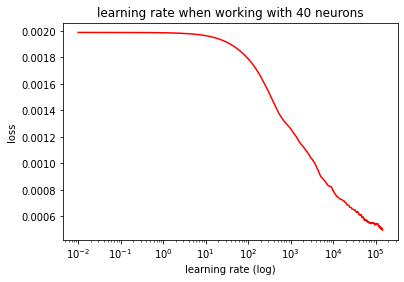

In [72]:
plt.plot(lr_test["params"]["lr"], lr_test["params"]["loss"], "r-")
plt.xlabel("learning rate (log)")
plt.ylabel("loss")
plt.xscale("log")
plt.title("learning rate when working with 40 neurons")
plt.show()

epoch 0/2000 loss 0.002410
epoch 100/2000 loss 0.001618
epoch 200/2000 loss 0.001406
epoch 300/2000 loss 0.001291
epoch 400/2000 loss 0.001220
epoch 500/2000 loss 0.001170
epoch 600/2000 loss 0.001145
epoch 700/2000 loss 0.001126
epoch 800/2000 loss 0.001103
epoch 900/2000 loss 0.001084
epoch 1000/2000 loss 0.001062
epoch 1100/2000 loss 0.001052
epoch 1200/2000 loss 0.001045
epoch 1300/2000 loss 0.001032
epoch 1400/2000 loss 0.001006
epoch 1500/2000 loss 0.000994
epoch 1600/2000 loss 0.000975
epoch 1700/2000 loss 0.000962
epoch 1800/2000 loss 0.000946
epoch 1900/2000 loss 0.000942


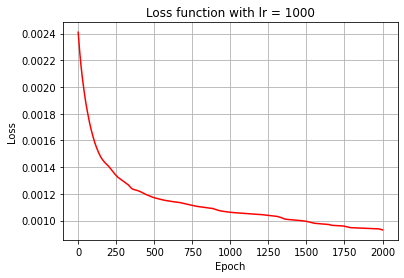

In [8]:
pred = Train_RNN(500, data["Data"].T, data["dt"], mu=data["mu"], n_iters=4000, lr=1000, verbose=True, loss_graph=True)

This code took 6min37s to run with 350 time step. We will show that our train model is almost identical to our true network. In fact, we had to put transparency over our true and train neuron activity because they were one over another. Here's a few neurons (choosen randomly):

In [32]:
t = np.linspace(0, 40, 500)

true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"], mu=data["mu"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"], mu=pred["params"]["mu"])[0]
untrain = rnn(t=t, IC=IC, dydx=dydx, W=pred["W0"], mu=pred["params"]["mu"])[0]

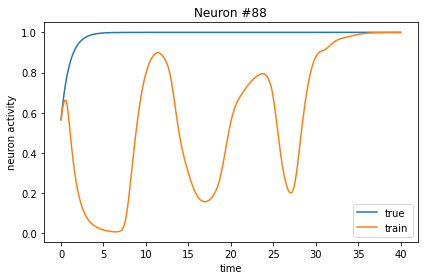

In [14]:
plt.plot(t, true[:,12], label="true")
plt.plot(t, train[:,12], label="train")
#plt.plot(t, untrain[:,12], label="untrain")
plt.title("Neuron #88")
plt.xlabel("time")
plt.ylabel("neuron activity")
plt.legend()
plt.tight_layout()

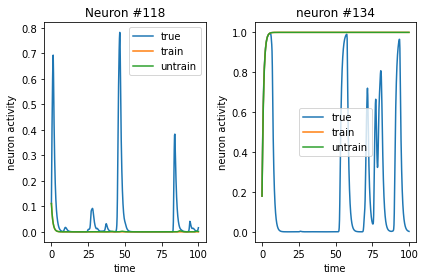

In [77]:
plt.figure(1)

plt.subplot(121)
plt.plot(t, true[:,118], label="true")
plt.plot(t, train[:,118], label="train")
plt.plot(t, untrain[:,118], label="untrain")
plt.title("Neuron #118")
plt.xlabel("time")
plt.ylabel("neuron activity")
plt.legend()
plt.tight_layout()
plt.subplot(122)
plt.plot(t, true[:,134], label="true")
plt.plot(t, train[:,134], label="train")
plt.plot(t, untrain[:,134], label="untrain")
plt.title("neuron #134")
plt.xlabel("time")
plt.ylabel("neuron activity")
plt.legend()
plt.tight_layout()
plt.show()

We can see that in every of those 4 demonstrations, we have identical behaviors within a big time frame. The time step were created using a time of 20 unit. However, we illustrated a time of 100 units and the model match perfectly with those conditions. We can use a last proof of concept with 4000 neurons and 172 time step. We will finally use a network with 1000 neurons and 100 time step.

In [41]:
n = 172
IC = np.random.rand(n)

data = GenerateData(n_data=100, time=10, IC=IC, mu=0, W=2*np.random.randn(n, n), ratio=1)

epoch 0/4000 loss 0.004400
epoch 100/4000 loss 0.001825
epoch 200/4000 loss 0.001522
epoch 300/4000 loss 0.001258
epoch 400/4000 loss 0.001195
epoch 500/4000 loss 0.001185
epoch 600/4000 loss 0.001165
epoch 700/4000 loss 0.001091
epoch 800/4000 loss 0.001051
epoch 900/4000 loss 0.001027
epoch 1000/4000 loss 0.000975
epoch 1100/4000 loss 0.000972
epoch 1200/4000 loss 0.000970
epoch 1300/4000 loss 0.000968
epoch 1400/4000 loss 0.000909
epoch 1500/4000 loss 0.000904
epoch 1600/4000 loss 0.000899
epoch 1700/4000 loss 0.000895
epoch 1800/4000 loss 0.000891
epoch 1900/4000 loss 0.000888
epoch 2000/4000 loss 0.000886
epoch 2100/4000 loss 0.000884
epoch 2200/4000 loss 0.000882
epoch 2300/4000 loss 0.000880
epoch 2400/4000 loss 0.000849
epoch 2500/4000 loss 0.000848
epoch 2600/4000 loss 0.000846
epoch 2700/4000 loss 0.000839
epoch 2800/4000 loss 0.000782
epoch 2900/4000 loss 0.000781
epoch 3000/4000 loss 0.000780
epoch 3100/4000 loss 0.000755
epoch 3200/4000 loss 0.000753
epoch 3300/4000 loss 0

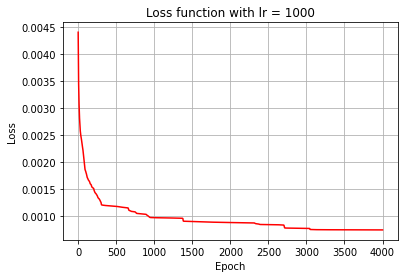

In [42]:
pred = Train_RNN(172, x=data["Data"].T, dt=data["dt"], mu=data["mu"], n_iters=4000, lr=1000, verbose=True, loss_graph=True)

In [44]:
t = np.linspace(0, 100, 1000)

true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"], mu=data["mu"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"], mu=pred["params"]["mu"])[0]
untrain = rnn(t=t, IC=IC, dydx=dydx, W=pred["W0"], mu=pred["params"]["mu"])[0]

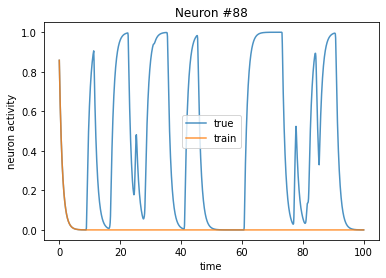

In [29]:
#plt.figure(1)

#plt.subplot(121)
plt.plot(t, true[:,12], alpha=0.8, label="true")
plt.plot(t, train[:,12], alpha=0.8, label="train")
#plt.plot(t, untrain[:,12], label="untrain")
plt.title("Neuron #88")
plt.xlabel("time")
plt.ylabel("neuron activity")
plt.legend()
#plt.tight_layout()

#plt.subplot(122)
#plt.plot(t, true[:,12], alpha=0.5, label="true")#
#plt.plot(t, train[:,12], alpha=0.5, label="train")
#plt.plot(t, untrain[:,12], label="untrain")
#plt.title("neuron #405")
#plt.xlabel("time")
#plt.ylabel("neuron activity")
#plt.legend()
#plt.tight_layout()
plt.show()

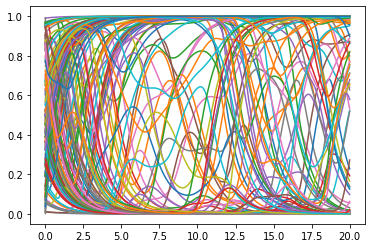

In [64]:
t = np.linspace(0, 20, 1000)
IC = np.random.rand(172)

data = GenerateData(n_data=500, time=10, IC=IC, W=2*np.random.randn(172, 172),ratio=1)

plt.plot(t, rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0])
plt.show()

C:\Users\Anthony\AppData\Local\Temp\ipykernel_18924\1733084498.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


epoch 0/6000 loss 0.000174
epoch 100/6000 loss 0.000154
epoch 200/6000 loss 0.000143
epoch 300/6000 loss 0.000134
epoch 400/6000 loss 0.000127
epoch 500/6000 loss 0.000122
epoch 600/6000 loss 0.000118
epoch 700/6000 loss 0.000114
epoch 800/6000 loss 0.000111
epoch 900/6000 loss 0.000108
epoch 1000/6000 loss 0.000105
epoch 1100/6000 loss 0.000103
epoch 1200/6000 loss 0.000101
epoch 1300/6000 loss 0.000099
epoch 1400/6000 loss 0.000097
epoch 1500/6000 loss 0.000096
epoch 1600/6000 loss 0.000095
epoch 1700/6000 loss 0.000095
epoch 1800/6000 loss 0.000094
epoch 1900/6000 loss 0.000094
epoch 2000/6000 loss 0.000093
epoch 2100/6000 loss 0.000092
epoch 2200/6000 loss 0.000091
epoch 2300/6000 loss 0.000090
epoch 2400/6000 loss 0.000089
epoch 2500/6000 loss 0.000088
epoch 2600/6000 loss 0.000087
epoch 2700/6000 loss 0.000086
epoch 2800/6000 loss 0.000085
epoch 2900/6000 loss 0.000083
epoch 3000/6000 loss 0.000081
epoch 3100/6000 loss 0.000079
epoch 3200/6000 loss 0.000078
epoch 3300/6000 loss 0

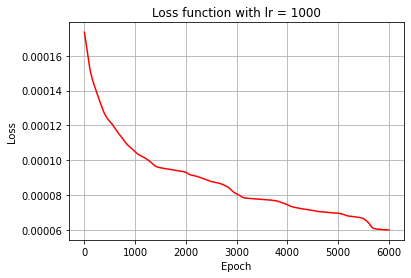

In [75]:
pred = Train_RNN2(172, data["Data"].T, data["dt"], mu=data["mu"], n_iters=6000, lr=1000, verbose=True, loss_graph=True)

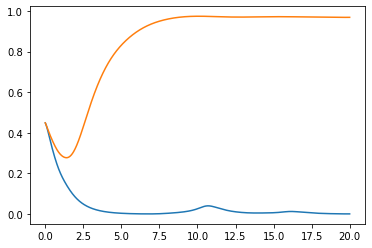

In [74]:
plt.plot(t, rnn(IC=IC, t=t, dydx=dydx, W=data["W"])[0][:,23])
plt.plot(t, rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0][:,23])
plt.show()